In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from glob import glob

In [3]:
def get_gv_framenum(config):
    """get_gv_framenum(config)
    
    returns arrays containing the frame indices of frames before and after green and violet excitation
    (PAPA and DR, respectively)"""
    
    def add_fw_and_flatten(x,ncycles,fwrange):
        rv = x.reshape(ncycles,1) + fwrange
        rv = rv.flatten()
        return rv
    
    IS = config['illumination_sequence']
    ncycles = IS['ncycles']
    r = IS['r']
    v = IS['v']
    g = IS['g']
    fw = IS['framewindow']
    gfirst = IS['gfirst']
    
    t = 4*r + v + g
    
    fwrange = np.arange(0,fw)
    
    if gfirst: # if the green pulse occurs first in the cycle
        gpre = np.arange(0,ncycles)*t # indices of frames in frame window before green
        gpost = np.arange(0,ncycles)*t + r + g # indices of frames in frame window after green
        vpre = np.arange(0,ncycles)*t + 2*r + g # indices of frames in frame window before violet
        vpost = np.arange(0,ncycles)*t + 3*r + v + g # indices of frames in frame window after violet
    else: # if the violet pulse occurs first in the cycle
        vpre = np.arange(0,ncycles)*t # indices of frames in frame window before violet
        vpost = np.arange(0,ncycles)*t + r + v # indices of frames in frame window after violet
        gpre = np.arange(0,ncycles)*t + 2*r + v # indices of frames in frame window before green
        gpost = np.arange(0,ncycles)*t + 3*r + v + g # indices of frames in frame window after green
    
    gpre = add_fw_and_flatten(gpre,ncycles,fwrange)
    gpost = add_fw_and_flatten(gpost,ncycles,fwrange)
    vpre = add_fw_and_flatten(vpre,ncycles,fwrange)
    vpost = add_fw_and_flatten(vpost,ncycles,fwrange)
    
    return({'vpre':vpre,'vpost':vpost,'gpre':gpre,'gpost':gpost})

In [4]:
config = {}
config['illumination_sequence'] = {'ncycles':5, 'r':30, 'v':0, 'g':0, 'framewindow':30, 'gfirst':False}
fnum = get_gv_framenum(config)

In [5]:
def getgv(filename):
    df = pd.read_csv(filename)
    deltav = df['frame'].isin(fnum['vpost']).sum() - df['frame'].isin(fnum['vpre']).sum()
    deltag = df['frame'].isin(fnum['gpost']).sum() - df['frame'].isin(fnum['gpre']).sum()
    return np.array([deltag/deltav, deltag, deltav])

In [6]:
# Calculate change in green and violet localizations and GV ratio
maxfnum = len(glob('../tracking/*.csv'))
allgv = [getgv(f'../tracking/{j}.csv') for j in range(1,maxfnum+1)]
allgv = np.array(allgv)

98
1.2037123824044516
819.704081632653
775.3163265306123


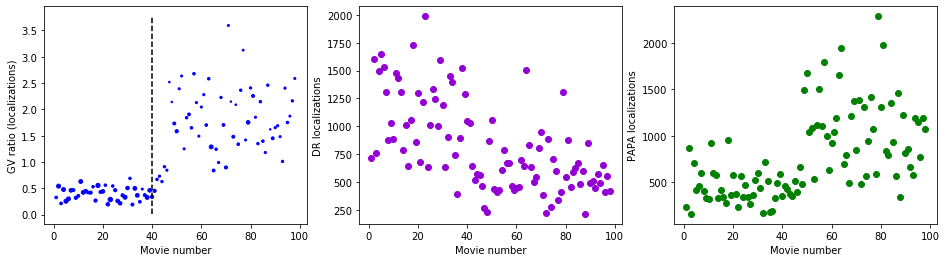

In [16]:
# Plot of GV ratio vs. time
# Point area corresponds to number of green + violet localizations
# s = np.abs(allgv[:,1:2].sum(axis=1)/30)
s = np.abs(allgv[:,2]/100)

fig,axs=plt.subplots(1,3,figsize=(16,4))
axs[0].scatter(np.arange(maxfnum)+1,allgv[:,0],s=s,color='blue')
# axs[0].scatter(np.arange(maxfnum)+1,allgv[:,0],color='blue')
print(maxfnum)
print(np.mean(allgv[:,0]))
axs[0].set_xlabel('Movie number')
axs[0].set_ylabel('GV ratio (localizations)');
# axs[0].set_ylim([0.1,1.1])
# axs[0].set_xlim([-10,210])

lims = axs[0].get_ylim()
axs[0].plot([40,40],lims,'k--')

axs[1].scatter(np.arange(maxfnum)+1,allgv[:,2],color='darkviolet')
print(np.mean(allgv[:,2]))
axs[1].set_xlabel('Movie number')
axs[1].set_ylabel('DR localizations');

axs[2].scatter(np.arange(maxfnum)+1,allgv[:,1],color='green')
print(np.mean(allgv[:,1]))
axs[2].set_xlabel('Movie number')
axs[2].set_ylabel('PAPA localizations');

np.savetxt('allgv.csv',allgv)
plt.savefig('GV_realtime.png',dpi=300,bbox_inches='tight')

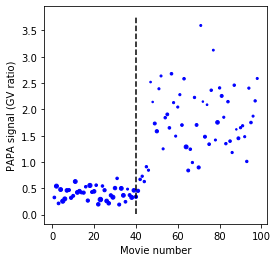

In [19]:
# Plot of GV ratio vs. time
# Point area corresponds to number of green + violet localizations
# s = np.abs(allgv[:,1:2].sum(axis=1)/30)
s = np.abs(allgv[:,2]/100)

fig,axs=plt.subplots(1,1,figsize=(4,4))
axs.scatter(np.arange(maxfnum)+1,allgv[:,0],s=s,color='blue')
axs.set_xlabel('Movie number')
axs.set_ylabel('PAPA signal (GV ratio)');

lims = axs.get_ylim()
axs.plot([40,40],lims,'k--')

plt.savefig('GV_ratio.png',dpi=300,bbox_inches='tight')

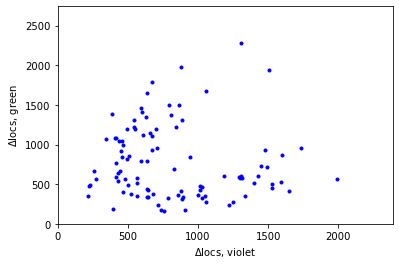

In [8]:
# Plot delta localizations for G vs. V
plt.plot(allgv[:,2],allgv[:,1],'.b')
plt.xlabel('$\Delta$locs, violet')
plt.ylabel('$\Delta$locs, green');
plt.xlim([0,allgv[:,2].max()*1.2])
plt.ylim([0,allgv[:,1].max()*1.2]);

1.2037123824044516


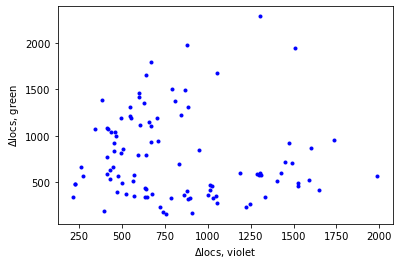

In [9]:
# Plot delta localizations for G vs. V with a maximum deltaV cutoff
maxv = 3000
sel = allgv[:,2]<maxv
plt.plot(allgv[sel,2],allgv[sel,1],'b.')
print((allgv[sel,1]/allgv[sel,2]).mean())
plt.xlabel('$\Delta$locs, violet')
plt.ylabel('$\Delta$locs, green');

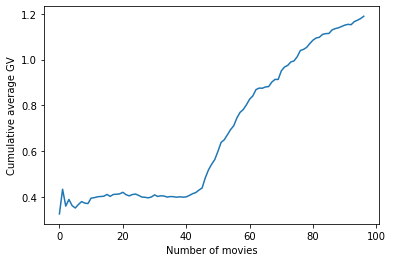

In [10]:
# Plot overall estimated GV ratio vs. number of files collected (to assess convergence)
plt.plot([(allgv[:j,1]/allgv[:j,2]).mean() for j in range(1,maxfnum)]);
plt.xlabel('Number of movies')
plt.ylabel('Cumulative average GV');

In [11]:
minfnum = 1
maxfnum = allgv.shape[0]
umperpx = 0.16
allgdisp = np.zeros((maxfnum-minfnum+1,50))
allvdisp = np.zeros((maxfnum-minfnum+1,50))
for j in range(minfnum,maxfnum+1):
    try:
        gd = np.genfromtxt(f'../displacements/{j}_gdisp.csv')
        vd = np.genfromtxt(f'../displacements/{j}_vdisp.csv')
        gh,gx = np.histogram(gd*umperpx,bins=np.arange(0,1.01,0.02));
        gh = gh/gh.sum()
        vh,vx = np.histogram(vd*umperpx,bins=np.arange(0,1.01,0.02));
        vh = vh/vh.sum()
        allgdisp[j-minfnum,:] = gh
        allvdisp[j-minfnum,:] = vh
    except:
        print(f'Glitch with {j}.')

In [24]:
vx

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ])

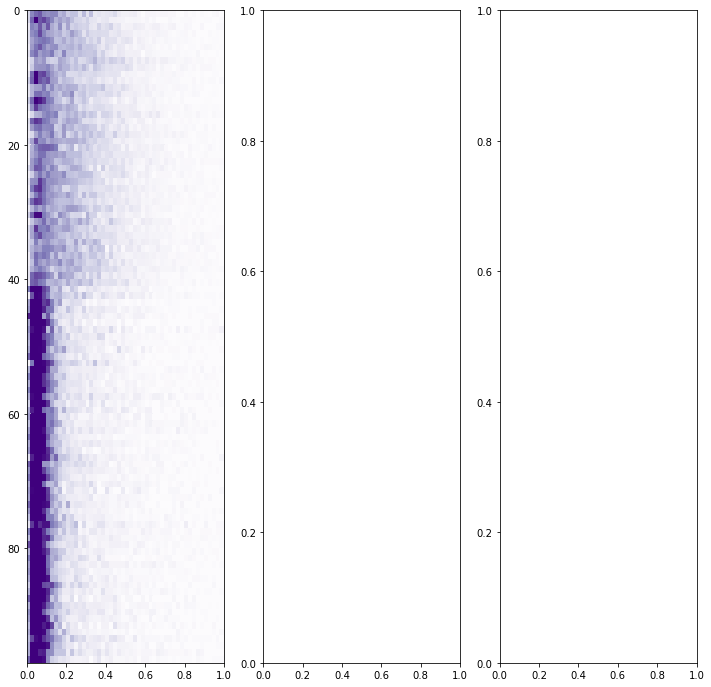

In [29]:
fig,axs=plt.subplots(1,3,figsize=(12,12))
axs[0].pcolor(vx,np.arange(allvdisp.shape[0]),allvdisp,cmap='Purples',vmin=0,vmax=0.1)
axs[0].invert_yaxis()
# axs[1].imshow(allgdisp,cmap='Greens',clim=[0,.1])
# axs[2].imshow(allgdisp-allvdisp,clim=[-.02,.02])
# plt.savefig('displacement_heatmap.png',dpi=300,bbox_inches='tight')

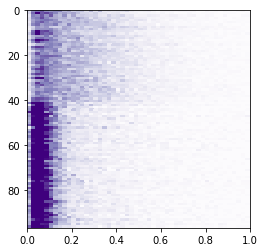

In [34]:
fig,axs=plt.subplots(1,1,figsize=(4,4))
axs.pcolor(vx,np.arange(allvdisp.shape[0]),allvdisp,cmap='Purples',vmin=0,vmax=0.1)
axs.invert_yaxis()
# axs[1].imshow(allgdisp,cmap='Greens',clim=[0,.1])
# axs[2].imshow(allgdisp-allvdisp,clim=[-.02,.02])
# plt.savefig('displacement_heatmap.png',dpi=300,bbox_inches='tight')

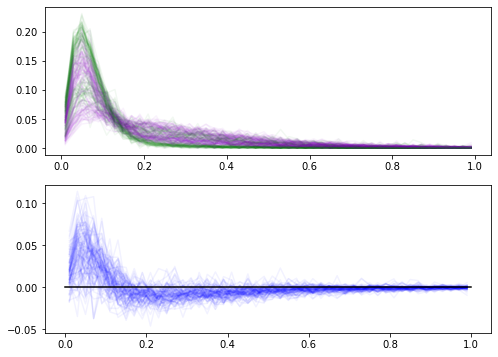

In [13]:
fig,axs=plt.subplots(2,1,figsize=(8,6))
bins = np.arange(0,1.01,0.02)
bincenters = (bins[1:]+bins[:-1])/2
for j in range(allvdisp.shape[0]):
    axs[0].plot(bincenters,allvdisp[j,:],color='darkviolet',alpha=.05)
    axs[0].plot(bincenters,allgdisp[j,:],color='green',alpha=.05)
    axs[1].plot(bincenters,(allgdisp-allvdisp)[j,:],color='blue',alpha=.05)
axs[1].plot([0,1],[0,0],color='k')

In [14]:
cp realtime_GV_scratch.ipynb ../../